In [5]:
%%time
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA, IncrementalPCA
import xgboost as xgb


# 讀取 CSV 檔案
df = pd.read_csv('./final_raw.csv')

# 根據 'span' 欄位篩選數據
sampled_df_list = []
for category in df['span'].unique():
    category_df = df[df['span'] == category]
    sample_n = min(len(category_df), 15000)  # 每個類別取 15000 筆或全部數據（如果不夠的話）
    sampled_df_list.append(category_df.sample(n=sample_n, random_state=42))  # 隨機取樣

# 合併篩選後的數據
df = pd.concat(sampled_df_list)

# 圖片處理函數
def process_image(image_name):
    image_path = os.path.join(images_folder, image_name)
    with Image.open(image_path) as img:
        return np.array(img.convert('L').resize((64, 64))).flatten()

# 設定您的圖片文件夾路徑
images_folder = './flipped_img'

# 處理所有圖片並將其作為特徵
with ThreadPoolExecutor(max_workers=12) as executor:
    df['image'] = list(executor.map(process_image, df['pic_id']))

# 將圖片數據展平並轉換為 NumPy 陣列
X_images = np.array(df['image'].tolist())

# 初始化 Incremental PCA，設定 n_components 為 16
incremental_pca = IncrementalPCA(n_components=16)

# IncrementalPCA 降維，分10批
for batch in np.array_split(X_images, 10): 
    incremental_pca.partial_fit(batch)

# 對圖片數據應用 PCA 降維
X_images_pca = incremental_pca.transform(X_images)

CPU times: total: 47min 49s
Wall time: 5min 42s


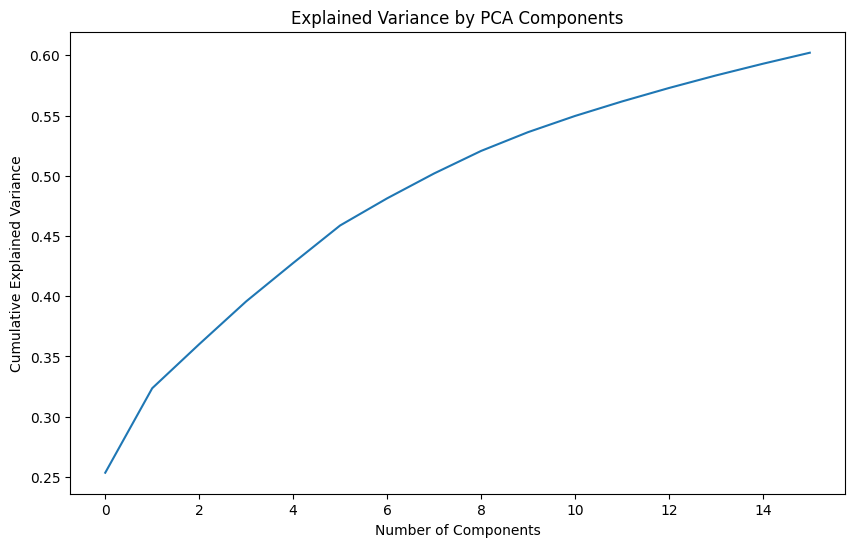

In [6]:
#PCA的方差解釋率
plt.figure(figsize=(10, 6))
explained_variance_ratio = incremental_pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

C:\Users\student\anaconda3\envs\da\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\student\anaconda3\envs\da\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


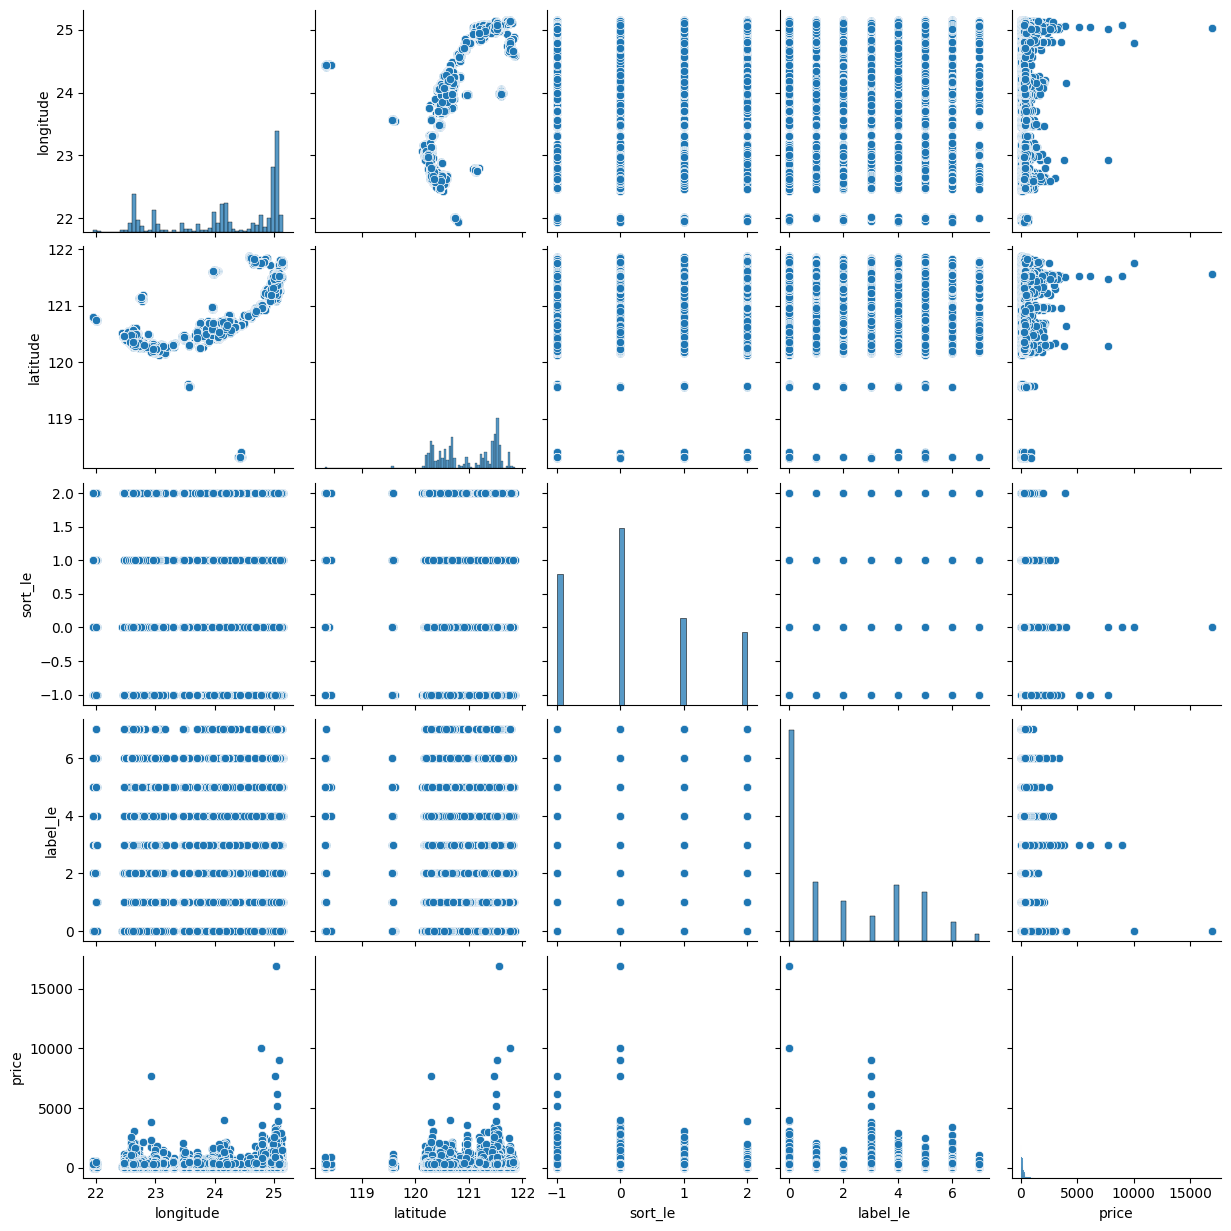

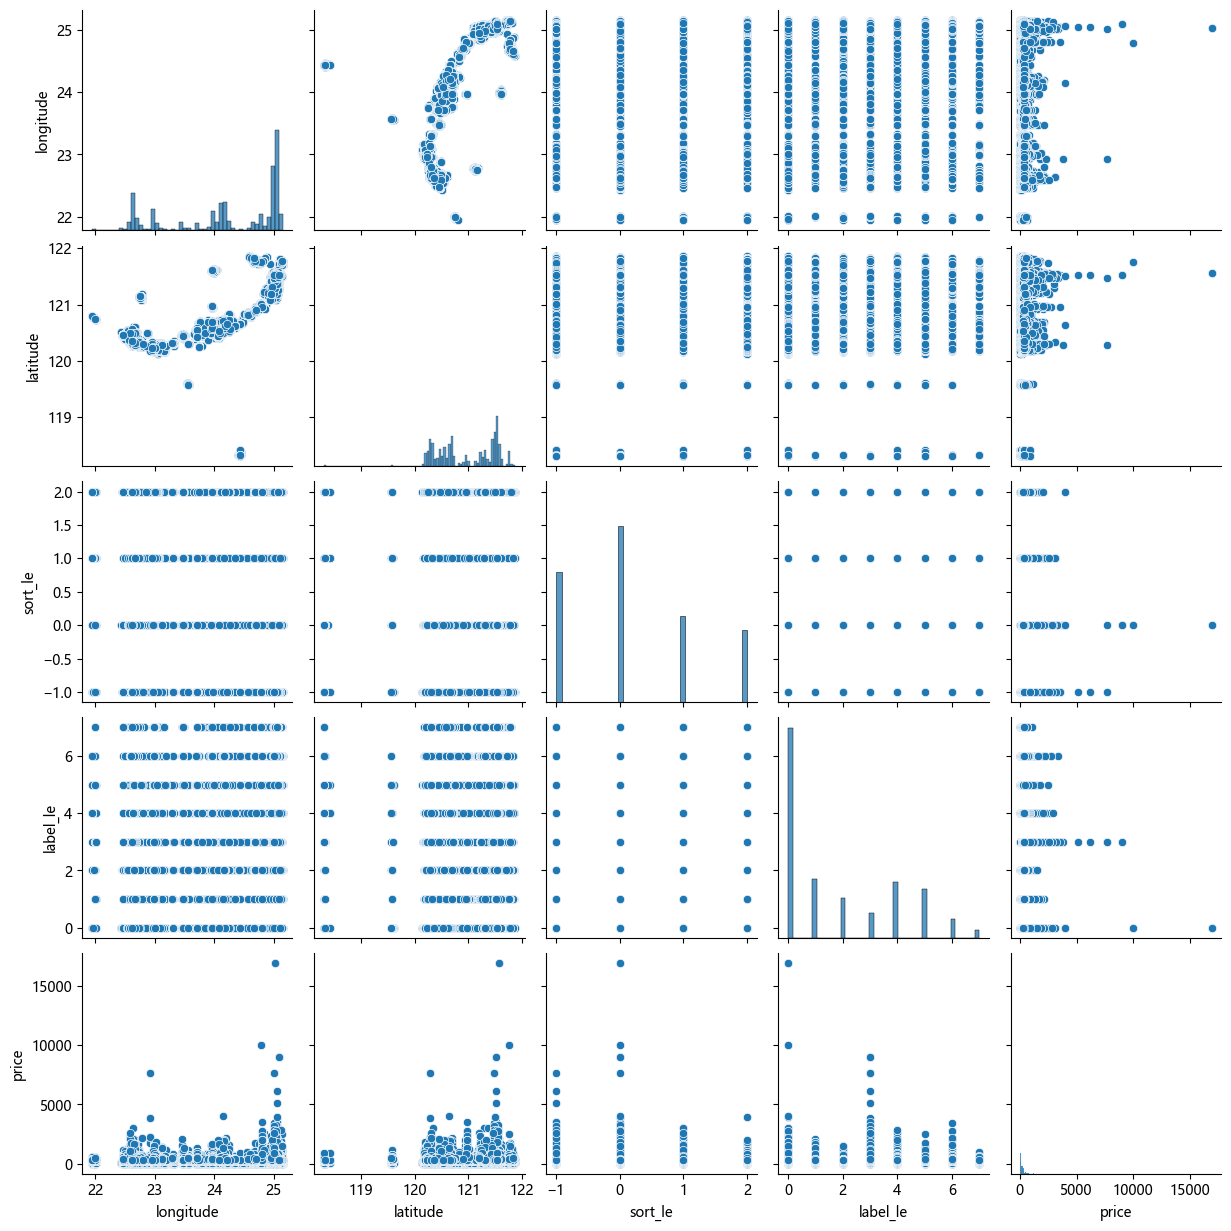

In [13]:
#散點圖們
sns.pairplot(df[['longitude', 'latitude', 'sort_le', 'label_le', 'price']])

#散點圖們
plt.rcParams['font.family'] = ['Microsoft YaHei']
sns.pairplot(df[['longitude', 'latitude', 'sort_le', 'label_le', 'price']])
#sns.pairplot(df[['longitude', 'latitude', 'sort', 'label', 'price']], height=2, aspect=2)
# 繪製 'sort' 列的計數圖


<Axes: >

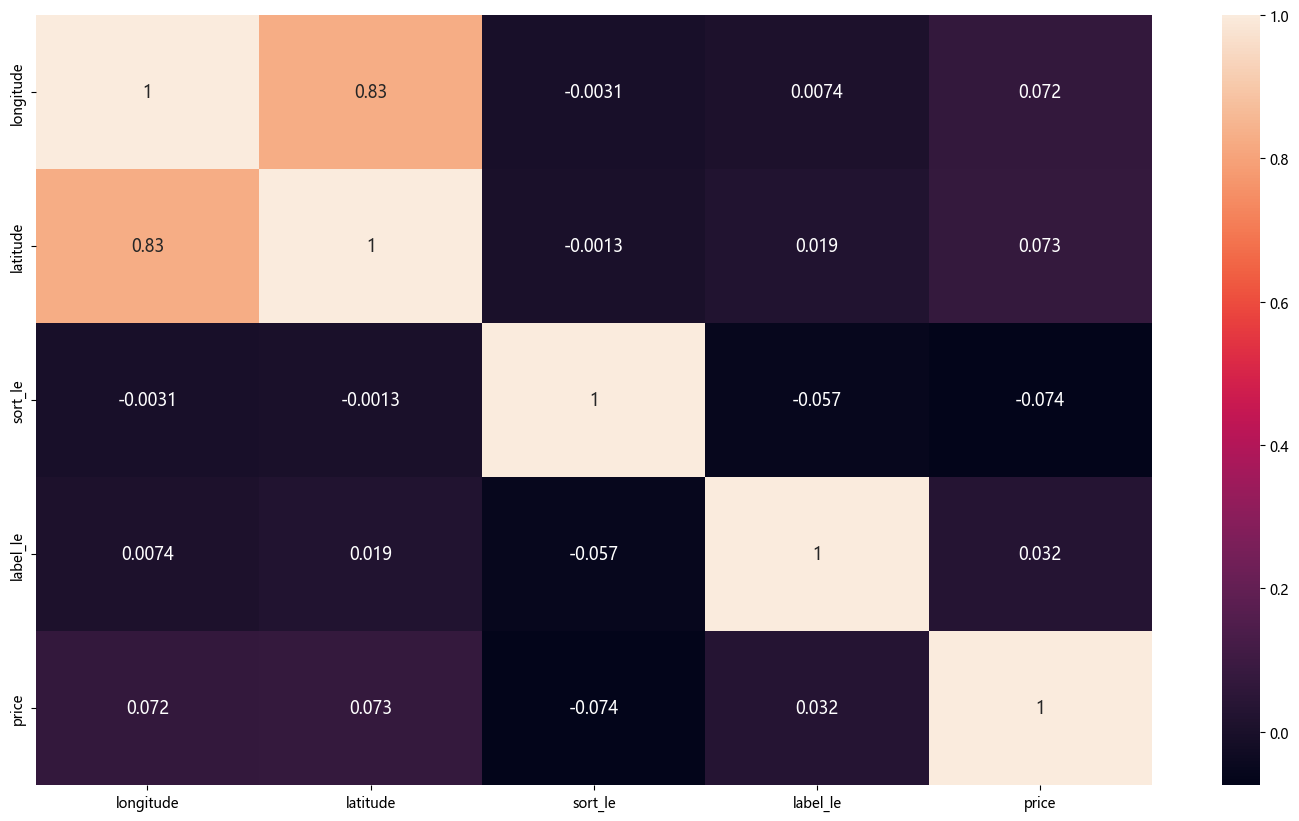

In [20]:
#熱力圖
selected_columns = df[['longitude', 'latitude', 'sort_le', 'label_le', 'price']]
corrmat = selected_columns.corr()
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(corrmat, annot=True, annot_kws={'size': 12})

In [21]:
#類別標籤編碼
df['sort_le'] = pd.factorize(df['sort'])[0]
df['label_le'] = pd.factorize(df['label'])[0]

# 目標變量
y = df['price']  

# 將其他特徵結合
X_other_features = df[['latitude', 'longitude','sort_le','label_le']]
X = np.hstack((X_images_pca, X_other_features))

In [24]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# 超參數組合
parameters = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'tree_method': ['hist'] 
}

# 訓練模型
xgb_model = xgb.XGBRegressor(n_jobs=1)
clf = GridSearchCV(xgb_model, parameters, cv=3, scoring='neg_mean_squared_error', verbose=2)
clf.fit(X_train, y_train)

# 輸出最佳參數和最佳分數
print("最佳參數：", clf.best_params_)
print("最佳分數：", clf.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, tree_met

[CV] END learning_rate=0.2, max_depth=5, n_estimators=50, tree_method=hist; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=50, tree_method=hist; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=   0.8s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=   0.8s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=   0.8s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, tree_method=hist; total time=   1.0s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, tree_method=hist; total time=   1.0s
[CV] END learning_rate=0.2, max_depth=5, n

Mean Squared Error: 36419.487234314205
Mean Absolute Error: 97.37198472706973
R^2 Score: 0.16924264068892925


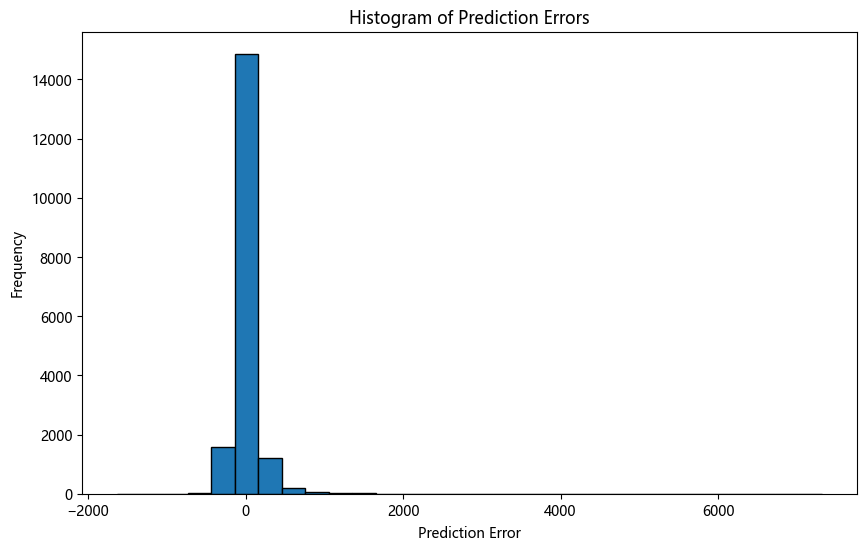

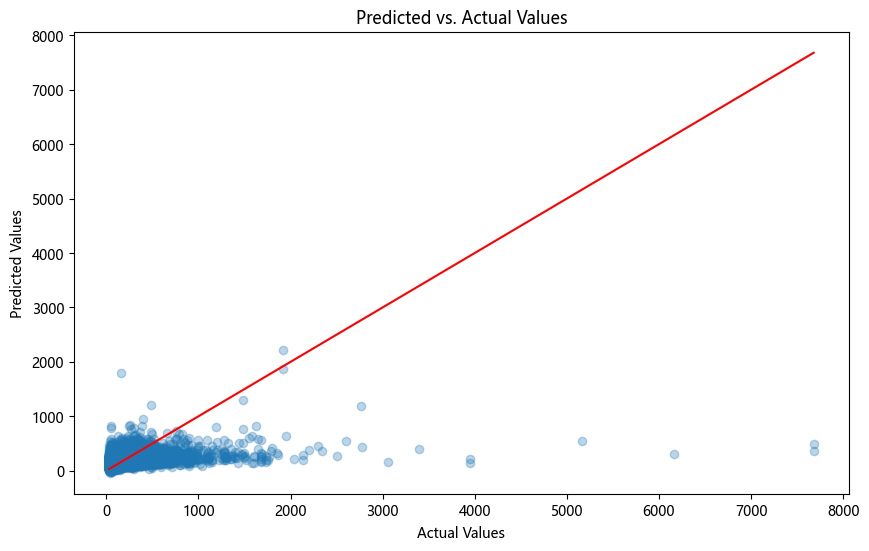

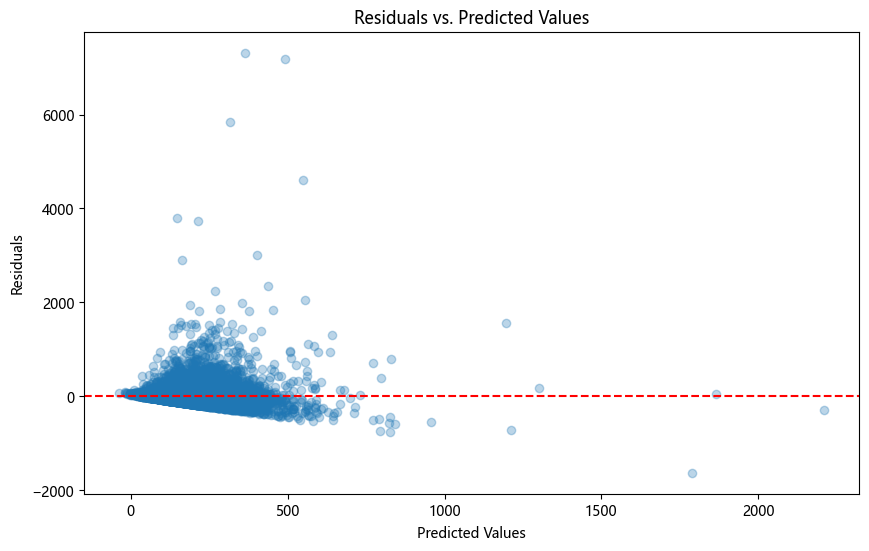

In [26]:
# 回歸評估
y_pred = clf.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

residuals = y_test - y_pred

# 繪製誤差直方圖
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# 繪製預測值與實際值的散點圖
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')  # 對角線
plt.show()

# 繪製殘差圖
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [30]:
%%time
from sklearn.preprocessing import LabelEncoder
#分類
# 拆分數據集
y = df['span'] 

# 重新編碼標籤
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=87)

# 超參數設置範例
parameters = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'tree_method': ['hist']
}

# 訓練分類模型
xgb_model = xgb.XGBClassifier(n_jobs=1)
clf = GridSearchCV(xgb_model, parameters, cv=3, scoring='accuracy', verbose=2)
clf.fit(X_train, y_train)

# 輸出最佳參數和最佳分數
print("最佳參數：", clf.best_params_)
print("最佳分數：", clf.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=   3.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=   4.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=   4.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, tree_met

[CV] END learning_rate=0.2, max_depth=5, n_estimators=50, tree_method=hist; total time=   2.1s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=50, tree_method=hist; total time=   2.1s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=   4.0s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=   4.0s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=   4.0s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=   7.1s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=   6.1s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=   7.1s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, tree_method=hist; total time=   7.7s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, tree_method=hist; total time=   7.7s
[CV] END learning_rate=0.2, max_depth=5, n

Accuracy: 0.37116666666666664
Precision: 0.3689517234810509
Recall: 0.37116666666666664
F1 Score: 0.3698936526548327


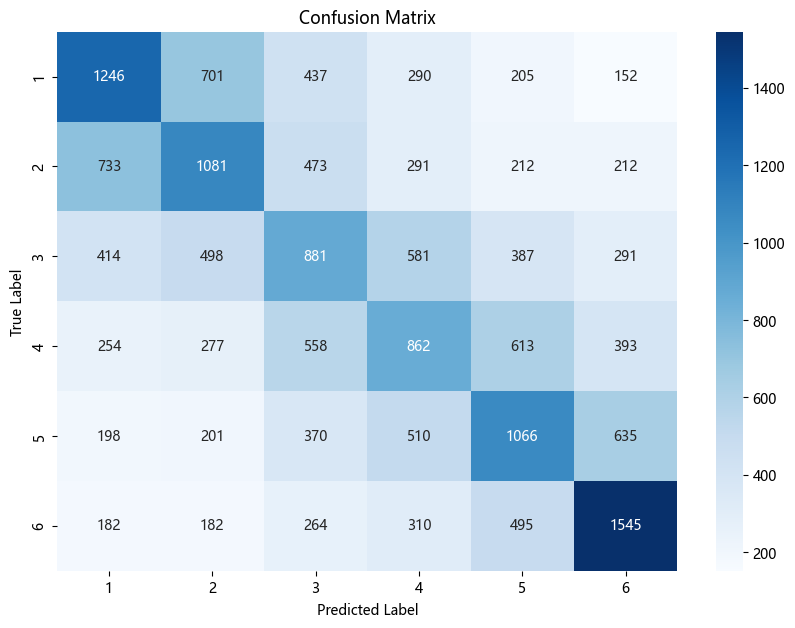

In [32]:
# 使用最佳模型预测
y_pred = clf.best_estimator_.predict(X_test)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# 混淆矩陣
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
class_names = [1, 2, 3, 4, 5, 6] 
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()

# 特徵工程後

In [34]:
%%time
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA, IncrementalPCA
import xgboost as xgb
import cv2

# 讀取 CSV 檔案
df = pd.read_csv('./final_raw.csv')

# 根據 'span' 欄位篩選數據
sampled_df_list = []
for category in df['span'].unique():
    category_df = df[df['span'] == category]
    sample_n = min(len(category_df), 15000)  # 每個類別取 15000 筆
    sampled_df_list.append(category_df.sample(n=sample_n, random_state=42))  # 隨機取樣

# 合併篩選後的數據
df = pd.concat(sampled_df_list)


# 圖片處理函數
def process_image(image_name, size=(64, 64)):
    image_path = os.path.join(images_folder, image_name)
    with Image.open(image_path) as img:
        img = img.convert('RGB').resize(size)
        img_array = np.array(img)

        # CANNY邊緣檢測
        edges = cv2.Canny(img_array, 100, 200)

        # 計算色彩頻率
        (hist, _) = np.histogram(img_array.ravel(), bins=128, range=(0, 256))
        hist = hist / hist.sum()

        # 特徵結合
        features = np.append(edges.flatten(), hist)

        return features

# 圖片路徑
images_folder = './flipped_img'  

# 處理所有圖片並將其作為特徵
with ThreadPoolExecutor(max_workers=12) as executor:
    df['image'] = list(executor.map(process_image, df['pic_id']))

# 將圖片數據展平並轉換為 NumPy 陣列
X_images = np.array(df['image'].tolist())


# 初始化 PCA，設定 n_components 為 16
incremental_pca = IncrementalPCA(n_components=16)

# IncrementalPCA 降维，可以分10批
for batch in np.array_split(X_images, 10): 
    incremental_pca.partial_fit(batch)

# 對圖片數據應用 PCA 降維
X_images_pca = incremental_pca.transform(X_images)

CPU times: total: 1h 20min 29s
Wall time: 26min 8s


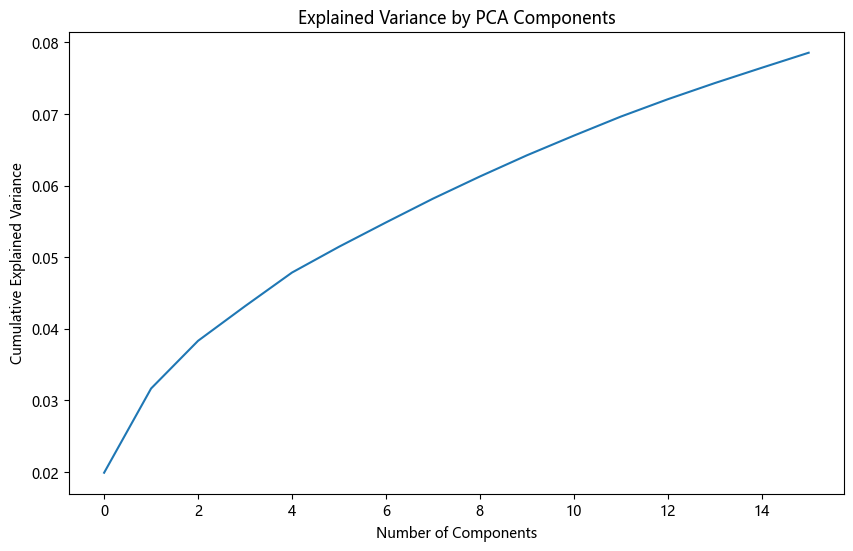

In [35]:
#PCA的方差解釋率
plt.figure(figsize=(10, 6))
explained_variance_ratio = incremental_pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [36]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

#建立編碼物件
one_hot_encoder = OneHotEncoder(sparse=False)

#餐點類別與評論單熱編碼
sort_one_hot = one_hot_encoder.fit_transform(df[['sort']])
label_one_hot = one_hot_encoder.fit_transform(df[['label']])

#minmax物件
scaler = MinMaxScaler()

#經緯度minmax
latitude_scaled = scaler.fit_transform(df[['latitude']])
longitude_scaled = scaler.fit_transform(df[['longitude']])

#特徵
X = np.hstack((X_images_pca, sort_one_hot, label_one_hot, latitude_scaled, longitude_scaled))
#目標
y = df['price']

C:\Users\student\anaconda3\envs\da\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\student\anaconda3\envs\da\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# 超參數設置範例，將'tree_method'從'gpu_hist'更改為'hist'
parameters = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'tree_method': ['hist'] 
}

# 訓練模型
xgb_model = xgb.XGBRegressor(n_jobs=1)
clf = GridSearchCV(xgb_model, parameters, cv=3, scoring='neg_mean_squared_error', verbose=2)
clf.fit(X_train, y_train)

# 輸出最佳參數和最佳分數
print("最佳參數：", clf.best_params_)
print("最佳分數：", clf.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=   4.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=   4.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=   5.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=   7.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=   7.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=   7.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, tree_met

[CV] END learning_rate=0.2, max_depth=5, n_estimators=50, tree_method=hist; total time=   4.6s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=50, tree_method=hist; total time=   4.6s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=   8.6s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=   8.6s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=   8.4s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=  12.7s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=  12.4s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=  12.7s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, tree_method=hist; total time=  16.7s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, tree_method=hist; total time=  16.6s
[CV] END learning_rate=0.2, max_depth=5, n

Mean Squared Error: 38464.19877747612
Mean Absolute Error: 98.96303765083353
R^2 Score: 0.12260115034555086


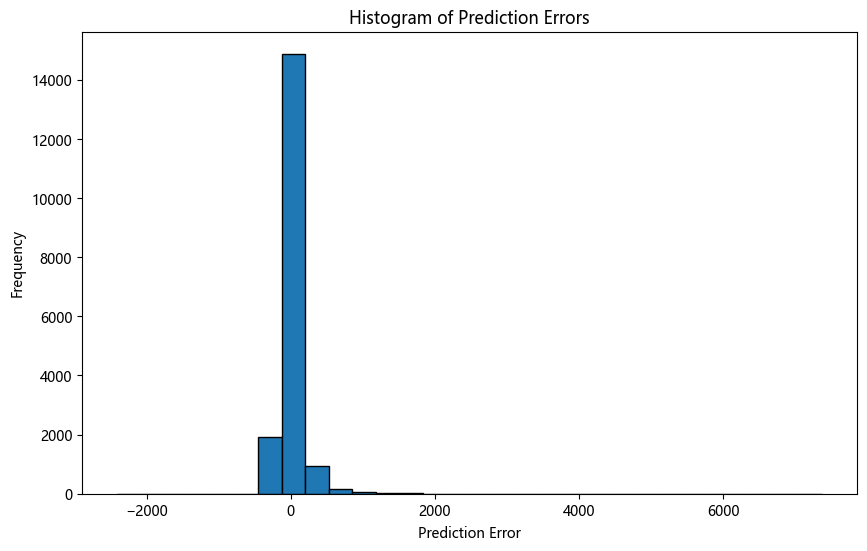

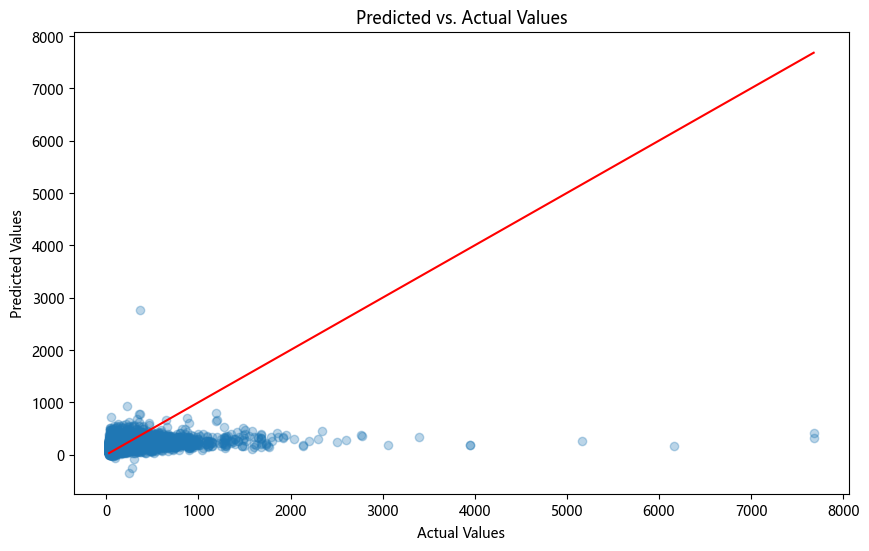

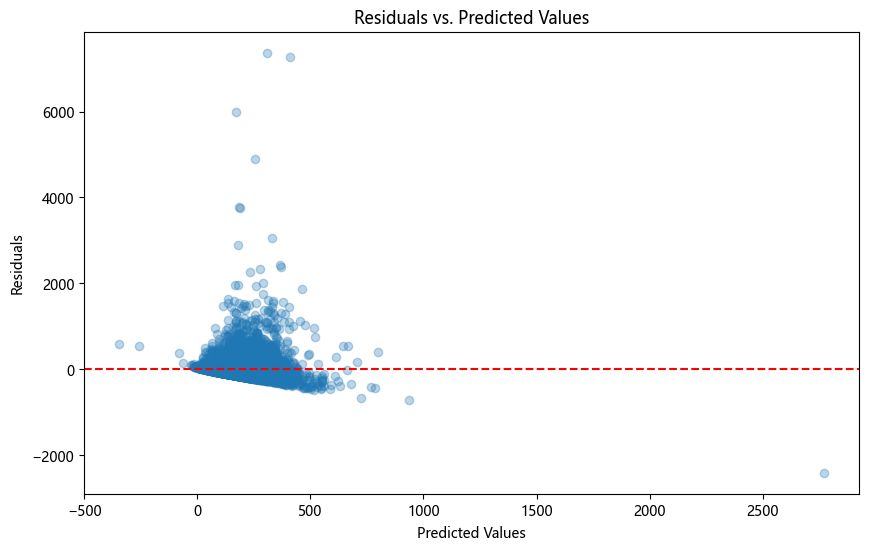

In [39]:
# 回歸評估
y_pred = clf.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

residuals = y_test - y_pred

# 繪製誤差直方圖
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# 繪製預測值與實際值的散點圖
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')  # 對角線
plt.show()

# 繪製殘差圖
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [40]:
%%time
from sklearn.preprocessing import LabelEncoder
#分類
# 拆分數據集
y = df['span'] 

# 重新編碼標籤
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 拆分數據集
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=87)

# 超參數設置範例
parameters = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'tree_method': ['hist']
}

# 訓練分類模型
xgb_model = xgb.XGBClassifier(n_jobs=1)
clf = GridSearchCV(xgb_model, parameters, cv=3, scoring='accuracy', verbose=2)
clf.fit(X_train, y_train)

# 輸出最佳參數和最佳分數
print("最佳參數：", clf.best_params_)
print("最佳分數：", clf.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=  14.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=  14.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, tree_method=hist; total time=  16.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=  37.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=  42.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, tree_method=hist; total time=  38.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=  59.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=  55.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=150, tree_method=hist; total time=  44.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, tree_met

[CV] END learning_rate=0.2, max_depth=5, n_estimators=50, tree_method=hist; total time=  18.0s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=50, tree_method=hist; total time=  18.0s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=  35.0s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=  34.6s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=100, tree_method=hist; total time=  34.6s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=  52.5s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=  52.2s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=150, tree_method=hist; total time=  51.8s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, tree_method=hist; total time= 1.2min
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, tree_method=hist; total time= 1.1min
[CV] END learning_rate=0.2, max_depth=5, n

Accuracy: 0.3653888888888889
Precision: 0.3623869476509213
Recall: 0.3653888888888889
F1 Score: 0.3636016492222181


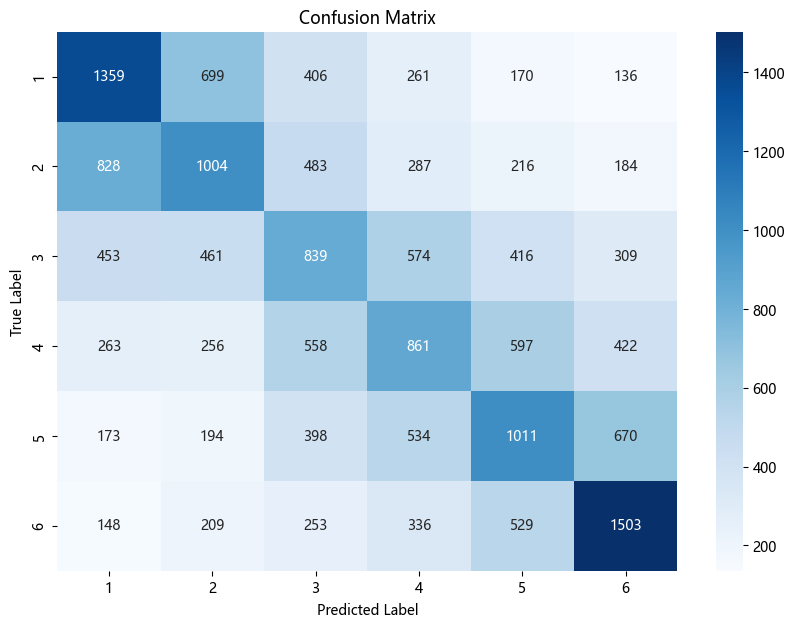

In [42]:
#分類評估
# 使用最佳模型预测
y_pred = clf.best_estimator_.predict(X_test)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# 混淆矩陣
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
class_names = [1, 2, 3, 4, 5, 6] 
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()